# 학습 목표
1. 물리화학적 특성 예측의 원리를 이해한다
2. QSPR(Quantitative Structure-Property Relationship) 모델링 방법을 학습한다
3. 물리화학적 특성 예측 모델을 구현하고 평가한다

# 1. 물리화학적 특성 예측
- QSPR(Quantitative Structure-Property Relationship) 모델링을 통해 화합물의 구조로부터 용해도, 분배계수(logP), 끓는점, 녹는점 등의 물리화학적 특성을 예측하는 과정
- 주요 물리화학적 특성:
    - 용해도(Solubility)
    - 분배계수(LogP)
    - 끓는점/녹는점
    - pKa(산해리상수)

# 2. 물리화학적 특성 예측 예제
<img src='https://www.j-octa.com/cases/caseA49/img/caseA48_img02.png'>

DeepChem을 이용해 그래프신경망을 구현하고 다양한 특징들을 구현해본다.
- DeepChem은 약물 발견, 재료 과학, 양자 화학 등의 분야에서 딥러닝을 적용하기 위한 오픈소스 파이썬 라이브러리
- 분자 표현, 특성 추출, 그래프 신경망 등 화학 정보학에 필요한 다양한 도구를 제공
- MoleculeNet 등 벤치마크 데이터셋 제공

In [ ]:
!pip install deepchem[tensorflow]
!pip install tensorflow==2.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully unin

In [ ]:
# 라이브러리 임포트
import deepchem as dc
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.metrics import mean_absolute_error, r2_score
from deepchem.feat import MolGraphConvFeaturizer
from deepchem.models import GraphConvModel

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## 2.1. 데이터세트 준비

In [ ]:
# 데이터셋 로드
print("데이터셋 로드 중...")
tasks_sol, datasets_sol, transformers_sol = dc.molnet.load_delaney(featurizer='GraphConv', split='random')
train_sol, valid_sol, test_sol = datasets_sol

print(f"용해도 데이터셋 크기 - 학습: {len(train_sol)}, 검증: {len(valid_sol)}, 테스트: {len(test_sol)}")

데이터셋 로드 중...
용해도 데이터셋 크기 - 학습: 902, 검증: 113, 테스트: 113
LogP 데이터셋 크기 - 학습: 3360, 검증: 420, 테스트: 420


용해도 데이터셋 샘플:


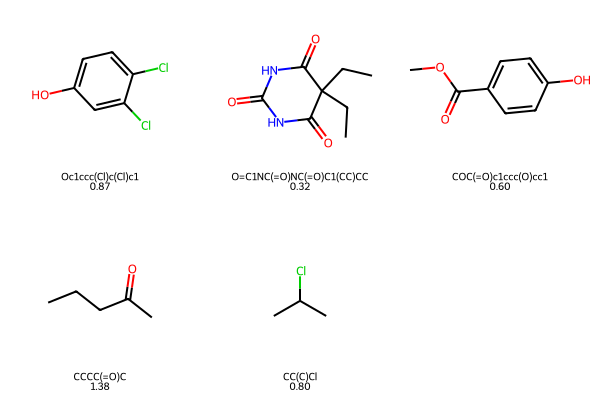

In [ ]:
# 데이터셋 샘플 확인
def display_molecules(dataset, n=5):
    mols = []
    for i in range(min(n, len(dataset.ids))):
        smiles = dataset.ids[i]
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mols.append(mol)

    legends = [f"{dataset.ids[i]}\n{dataset.y[i][0]:.2f}" for i in range(len(mols))]
    img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200), legends=legends)
    return img

# 용해도 데이터셋 분자 시각화
print("용해도 데이터셋 샘플:")
img_sol = display_molecules(train_sol)
display(img_sol)

## 2.2. 그래프 합성곱 신경망(GCN) 학습
DeepChem의 GraphConvModel을 사용하여 그래프 합성곱 신경망을 학습

In [ ]:
# 그래프 합성곱 모델 설정 (용해도 예측)
n_tasks_sol = len(tasks_sol)
batch_size = 32
model_dir = './model_solubility'

# 모델 정의
solubility_model = dc.models.GraphConvModel(
    n_tasks=n_tasks_sol,
    batch_size=batch_size,
    mode='regression',
    dropout=0.2,
    model_dir=model_dir,
    learning_rate=0.001,
)

# 모델 학습
print("용해도 예측 모델 학습 중...")
solubility_model.fit(train_sol, nb_epoch=50)

용해도 예측 모델 학습 중...


0.16370203018188476

## 2.3. 모델 평가

In [ ]:
# 모델 평가
print("용해도 예측 모델 평가 중...")
train_scores = solubility_model.evaluate(train_sol, metrics=[
    dc.metrics.Metric(dc.metrics.mean_absolute_error),
    dc.metrics.Metric(dc.metrics.r2_score)
])
valid_scores = solubility_model.evaluate(valid_sol, metrics=[
    dc.metrics.Metric(dc.metrics.mean_absolute_error),
    dc.metrics.Metric(dc.metrics.r2_score)
])
test_scores = solubility_model.evaluate(test_sol, metrics=[
    dc.metrics.Metric(dc.metrics.mean_absolute_error),
    dc.metrics.Metric(dc.metrics.r2_score)
])

print("용해도 예측 모델 성능:")
print(f"학습 세트 - MAE: {train_scores['mean_absolute_error']:.4f}, R²: {train_scores['r2_score']:.4f}")
print(f"검증 세트 - MAE: {valid_scores['mean_absolute_error']:.4f}, R²: {valid_scores['r2_score']:.4f}")
print(f"테스트 세트 - MAE: {test_scores['mean_absolute_error']:.4f}, R²: {test_scores['r2_score']:.4f}")

용해도 예측 모델 평가 중...
용해도 예측 모델 성능:
학습 세트 - MAE: 0.3504, R²: 0.8066
검증 세트 - MAE: 0.4440, R²: 0.6889
테스트 세트 - MAE: 0.4230, R²: 0.7219


## 2.4. 시각화

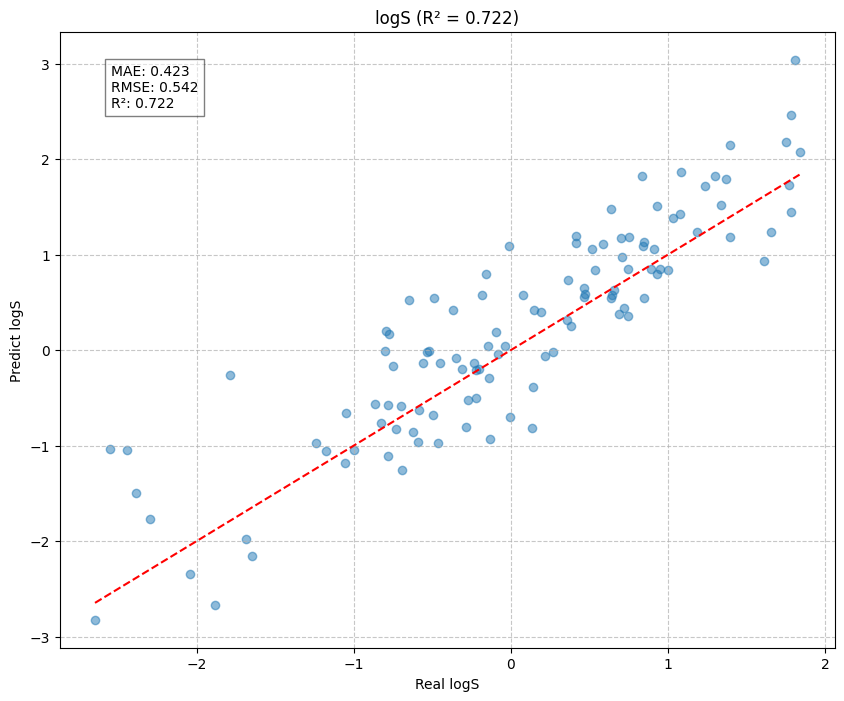

In [ ]:
# 예측 결과 시각화
def visualize_predictions(model, dataset, property_name):
    y_true = dataset.y.flatten()
    y_pred = model.predict(dataset).flatten()

    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel(f'Real {property_name}')
    plt.ylabel(f'Predict {property_name}')
    plt.title(f'{property_name} (R² = {r2_score(y_true, y_pred):.3f})')
    plt.grid(True, linestyle='--', alpha=0.7)

    # 통계 정보 추가
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))

    plt.text(min(y_true) + 0.1, max(y_pred) - 0.5,
             f'MAE: {mae:.3f}\nRMSE: {rmse:.3f}\nR²: {r2:.3f}',
             bbox=dict(facecolor='white', alpha=0.5))

    return plt

# 용해도 예측 결과 시각화
solubility_viz = visualize_predictions(solubility_model, test_sol, 'logS')
solubility_viz.savefig('solubility_predictions.png')
solubility_viz.show()